1. 동전 이미지를 이용한 윤곽선, opencv (이미지 검출, 히스토그램, 레이블 지정 등)

2. 이미지 영상 + CNN 기법 접목
  - 데이터를 학습데이터 로드
  - 데이터를 늘이는 방법
  - 데이터를 생성하는 방법

3. 학습, 예측율

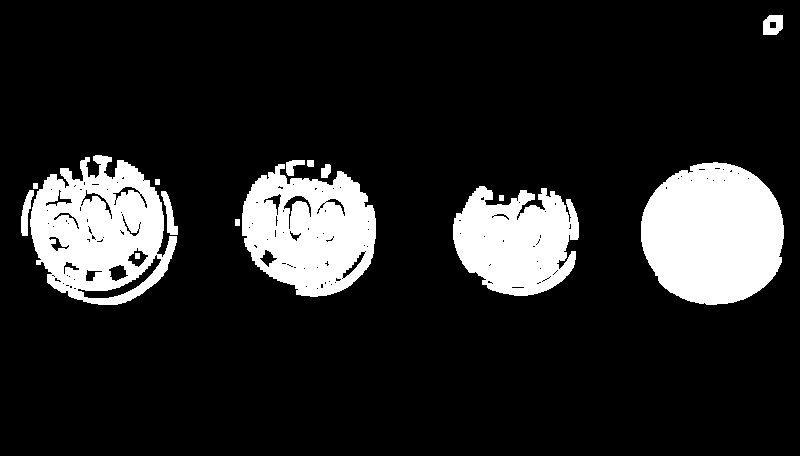

In [1]:
# 1. 동전이미지 윤곽 분리하는 방법 : cv2.watershed()
# 2. 2진화작업 -> 흑백 -> 노이즈제거 -> sure Background  추출 (cv2.dilat())
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def imshow(img):
    ret, encoded = cv2.imencode(".png",img)
    display(Image(encoded))
    
img = cv2.imread("c:\\test\\coin01.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#2진화 작업
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#노이즈 제거
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations = 2)
imshow(bin_img)

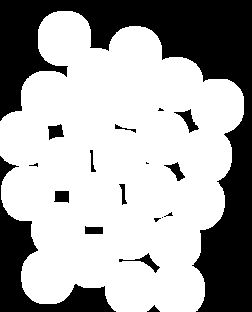

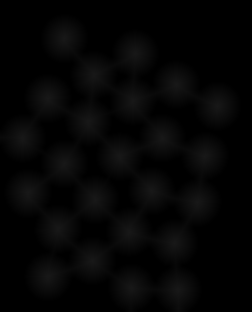

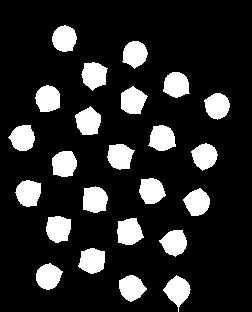

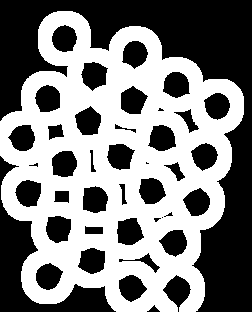

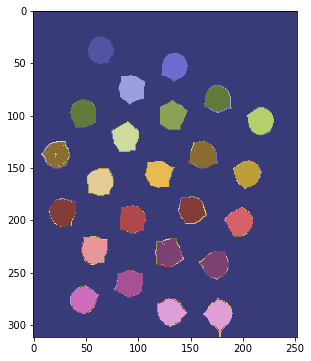

In [7]:
# 1. 동전이미지 윤곽 분리하는 방법 : cv2.watershed()
# 2. 2진화작업 -> 흑백 -> 노이즈제거 -> sure Background  추출 (cv2.dilat())
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def imshow(img):
    ret, encoded = cv2.imencode(".png",img)
    display(Image(encoded))
    
img = cv2.imread("c:\\test\\coin02.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #흑백

#2진화 작업
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#노이즈 제거
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations = 2)
#imshow(bin_img)

# sure Background 추출 (대상을 그룹으로 만들고 -> 배경과 그룹을 분리한다.)
sure_bg = cv2.dilate(bin_img,kernel, iterations = 3)
imshow(sure_bg)

# 거리를 구한다.
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist)

ret, sure_fg = cv2.threshold(dist, 0.5*dist.max(),255,cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg)

#배경인지 전경인지 구분할 수 없는 영역이 된다.
unknow = cv2.subtract(sure_bg, sure_fg)
imshow(unknow)

#레이블 0 : 전경또는 배경인지 모르는 영역
#레이블 1 : 배경
#레이블 2 : 대상(물체)
#레이블 설정 cv2.connectedComponents()
ret, markers = cv2.connectedComponents(sure_fg)

markers += 1
markers[unknow == 255] = 0

fig,ax = plt.subplots(figsize = (6,6))
ax.imshow(markers, cmap = 'tab20b')
plt.show()

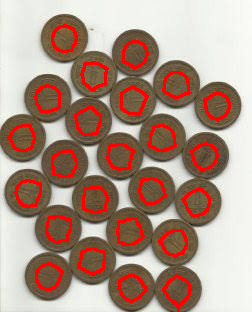

In [10]:
#watershed 알고리즘을 이용해서 윤곽선 추출
labels = np.unique(markers)
coins = []
for label in labels[2:]:
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    #윤곽추출
    cnt,hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(cnt[0])
    
cv2.drawContours(img, coins, -1, color = (0,0,255), thickness = 2)
imshow(img)

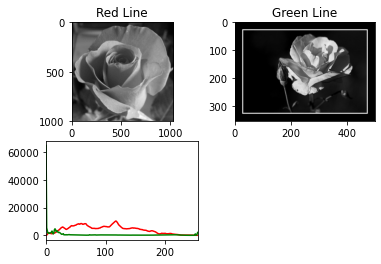

In [12]:
# 1 - 2. 히스토그램
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

img1 = cv2.imread('c:\\test\\flower1.jpg',0)
img2 = cv2.imread('c:\\test\\flower2.jpg',0)

hist1 = cv2.calcHist([img1],[0],None,[256],[0,256])
hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])

plt.subplot(221),plt.imshow(img1,'gray'),plt.title('Red Line')
plt.subplot(222),plt.imshow(img2,'gray'),plt.title('Green Line')
plt.subplot(223),plt.plot(hist1,color = 'r'),plt.plot(hist2, color = 'g')
plt.xlim([0,256])
plt.show()


In [19]:
#2. 데이터 이미지 늘리는 방법
import os
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
DATA_DIR = "c:\\test"
IMAGE_NAME = "apple.jpg"
SAVE_DIR = os.path.join(DATA_DIR,'preview')  #데이터를 부풀여서 저장할 디렉토리

datagen = ImageDataGenerator(rotation_range = 40, width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            fill_mode = 'nearest',
                            horizontal_flip = True)

im_array = cv2.imread(os.path.join(DATA_DIR,IMAGE_NAME)) #이미지 로드
# 차원 변환
im_array = im_array.reshape((1,) + im_array.shape) # 4차원으로 변환

#대상 디렉토리 없으면 만들자
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    
i = 0

#이미지 배치를 하자
for batch in datagen.flow(im_array, batch_size = 1, save_to_dir = SAVE_DIR, save_prefix = 'apple',
                         save_format = 'jpg'):
    i += 1
    if i == 10:
        break
        
datagen.flow(im_array, batch_size = 1, save_to_dir = SAVE_DIR, save_prefix = 'apple', save_format = 'jpg')

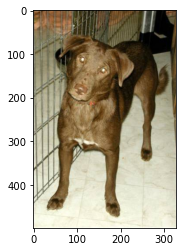

In [21]:
#2. 이미지 영상 + CNN 기법 접목
#- 데이터를 학습데이터 로드
#- 데이터를 생성하는 방법
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "C:\\petimage"
CATEGORIES = ["dogs", "cats"]
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for image_name in os.listdir(path):
        img_array = cv2. imread(os.path.join(path, image_name),)
        img_array = cv2. cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array, cmap = 'gray')
        plt.show()
        break
    break

학습 데이터 레이블 :  1
학습 데이터 레이블 :  1
학습 데이터 레이블 :  1
학습 데이터 레이블 :  1


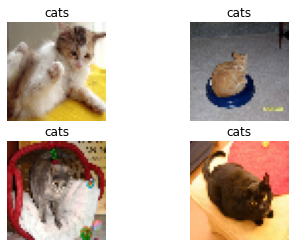

In [27]:
#2. 이미지 영상 + CNN 기법 접목
    #- 데이터를 학습데이터 로드 :
    #
#- 데이터를 생성하는 방법
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

DATADIR = "C:\\petimage"
CATEGORIES = ["dogs", "cats"]
training_data = []
IMG_SIZE = 50

def create_training_data():
    for class_num, category in enumerate(CATEGORIES) :
        path = os.path.join(DATADIR, category)
        for image_name in os.listdir(path):
            try: #이미지 로드, 크기조정, 데이터 레이블 정보추가
                img_array = cv2. imread(os.path.join(path, image_name))
                #img_array = cv2. imread(os.path.join(path, image_name),cv2.IMREAD_GRAYSCALE)
                img_resize_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE)) #이미지 크기 조정
                training_data.append([img_resize_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(training_data)

X_train = [] #이미지 데이터
y_train = [] #레이블 정보

#데이터 셋 설정
for feature, label in training_data :
    X_train.append(feature)
    y_train.append(label)

#numpy로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

#데이터 셋 확인
for i in range(0,4):
    print("학습 데이터 레이블 : ", y_train[i])
    plt.subplot(2,2,i+1)
    plt.axis('off')
    plt.title(label = "dogs" if y_train[i] == 0 else 'cats')
    #plt.imshow(X_train[i], cmap = 'gray')
    
    img_array= cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)

In [31]:
#모델 생성
from keras import layers, models, optimizers

#순차모델 생성
model = models.Sequential()

#Conv2D -> 4
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

#1차원
model.add(layers.Flatten())
model.add(layers.Dense(512,activation = 'relu'))

#출력
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [32]:
!pip install extra_keras_datasets